## Mouse Hippocampus Analysis

**Date** : 2021-10-05<br>
**Author** : Alma Andersson<br>
**Description** : This notebook outlines the analysis related to the mouse hippocampus data.

load the necessary libraries

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import scanpy as sc

import os.path as osp
import os
from PIL import Image

import anndata as ad
import pandas as pd
import sys

import eggplant as eg


set the figure/plotting parameters

In [2]:
from matplotlib import rcParams
rcParams["figure.facecolor"] = "None"
rcParams["axes.facecolor"] = "None"

specify data directories

In [3]:
MAIN_DIR = "../data/mouse-hippocampus/"
DATA_DIR = osp.join(MAIN_DIR,"curated")
REF_DIR = osp.join(MAIN_DIR,"references")
IMG_RES_DIR = "../../res/analysis/mouse-hippocampus/images/"

Toogle `SAVE_MODE`

In [4]:
SAVE_MODE = True

load reference and landmarks, inspect it to make sure everything is correctly formatted

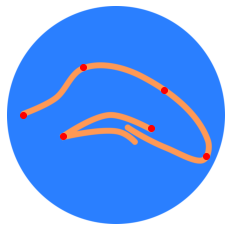

In [5]:
ref_img = Image.open(osp.join(REF_DIR,"reference.png"))
ref_lmk = pd.read_csv(osp.join(REF_DIR,"landmarks.tsv"),
                      sep="\t",
                      header = 0,
                      index_col=0)

plt.imshow(ref_img)
plt.scatter(ref_lmk.x_coord,ref_lmk.y_coord,c = "red")
plt.axis("off")
plt.show()

create grid from the reference image, we let `n_regions=2` since we have two regions in our reference.

In [6]:
grid_crd,mta = eg.pp.reference_to_grid(ref_img,
                                    n_approx_points=1000,
                                    n_regions= 2,  
                                    )

plot the grid-based reference, to ensure the conversion went as expected

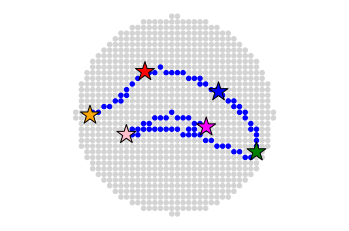

In [7]:
n_lmk = ref_lmk.shape[0]
lmk_cmap = eg.pl.ColorMapper(eg.C.LANDMARK_CMAP)
mta_cmap = {0:"lightgray",1:"blue"}

plt.scatter(grid_crd[:,0],
            grid_crd[:,1],
            c = [mta_cmap[x] for x in mta],
            s = 20)
plt.axis("equal")
plt.axis("off")
plt.scatter(ref_lmk.x_coord,
            ref_lmk.y_coord,
            c = lmk_cmap(ref_lmk),
            s = 400,
            marker = "*",
            edgecolor = "black",
            )


plt.gca().invert_yaxis()
plt.show()

Create a reference object

In [8]:
ref = eg.m.Reference(grid_crd,
                      landmarks = ref_lmk.values,
                      meta = dict(region = mta)
                    )

Specify paths to data

In [9]:
VIS_PTH = osp.join(DATA_DIR,"hippo-visium.h5ad")
SS_PTH = osp.join(DATA_DIR, "hippo-slide_seq.h5ad")

load data (`AnnData`objects)

In [10]:
adata_1 = ad.read_h5ad(VIS_PTH)
adata_2 = ad.read_h5ad(SS_PTH)
adatas = {"Visium":adata_1,"Slide-seqV2":adata_2}

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Preprocess data

In [11]:
sc.pp.filter_cells(adata_2,min_counts=100)
for adata in adatas.values():
    eg.pp.default_normalization(adata)
    eg.pp.match_scales(adata,ref)
    eg.pp.get_landmark_distance(adata,reference=ref) 
    


/home/alma.andersson/miniconda3/envs/eggplant/lib/python3.8/site-packages/pandas-1.3.1-py3.8-linux-x86_64.egg/pandas/core/arrays/categorical.py:2630: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Inspect `AnnData` objects

In [12]:
adatas

{'Visium': AnnData object with n_obs × n_vars = 841 × 19814
     obs: 'in_tissue', 'array_row', 'array_col', 'total'
     var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mean', 'std'
     uns: 'curated_landmarks', 'spatial', 'log1p'
     obsm: 'spatial', 'landmark_distances',
 'Slide-seqV2': AnnData object with n_obs × n_vars = 41798 × 23237
     obs: 'xcoord', 'ycoord', 'n_counts'
     var: 'Gene', 'n_cells', 'mean', 'std'
     uns: 'curated_landmarks', 'spatial', 'log1p'
     obsm: 'spatial', 'landmark_distances'}

Visualize the observed data and the genes of interest

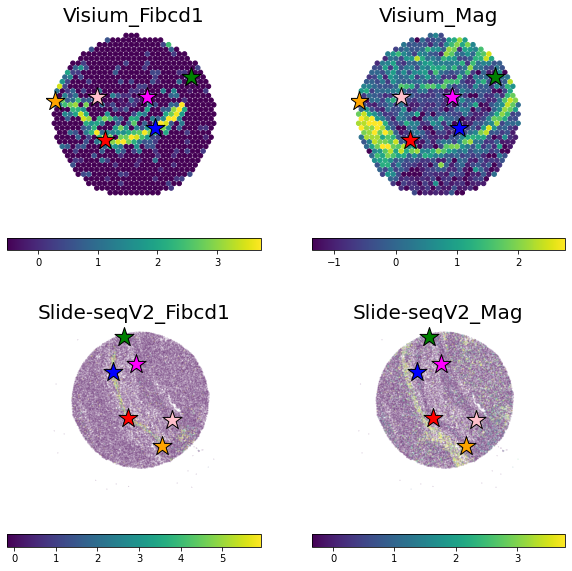

In [20]:
GENES = ["Fibcd1","Mag"]
fig,ax = eg.pl.visualize_observed(adatas,
                         features = GENES,
                         n_cols = 2,
                         n_rows = 2,
                         include_title = True,
                         fontsize = 20,
                         marker_size =[20,0.005],
                         share_colorscale = False,
                         separate_colorbar = False,
                         side_size = 5,
                         landmark_marker_size = 400,
                         show_landmarks = True,
                         quantile_scaling = True,
                         colorbar_fontsize = 10,
                         return_figures = True,
                        )

if SAVE_MODE:
    if SAVE_MODE: fig.savefig(osp.join(IMG_RES_DIR,"supp","mouse-hippocampus-observed.png"),bbox_inches="tight")

Transfer data to the reference

In [14]:
losses = eg.fun.transfer_to_reference(adatas,
                                GENES,
                                ref,
                                subsample=[1,0.2],
                                n_epochs=1000,
                                device ="gpu",
                                verbose = True,
                                return_losses = True,
                                return_models =False,
                                max_cg_iterations = 10000,
                               )

[Processing] ::  Model : Visium | Feature : Fibcd1 | Transfer : 1/4


/home/alma.andersson/miniconda3/envs/eggplant/lib/python3.8/site-packages/eggplant-0.1-py3.8.egg/eggplant/models.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/alma.andersson/miniconda3/envs/eggplant/lib/python3.8/site-packages/eggplant-0.1-py3.8.egg/eggplant/models.py:70: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  0%|                                     | 0/1000 [00:00<?, ?it/s]/home/alma.andersson/miniconda3/envs/eggplant/lib/python3.8/site-packages/gpytorch-1.5.0-py3.8.egg/gpytorch/utils/linear_cg.py:266: UserWarning: An output with one or more elements was resized since it had shape [11], which does not match the required output shape [1, 11].This behavior is deprecated,

[Processing] ::  Model : Visium | Feature : Mag | Transfer : 2/4


/home/alma.andersson/miniconda3/lib/python3.8/site-packages/anndata-0.7.5-py3.8.egg/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
100%|██████████████████████████| 1000/1000 [00:21<00:00, 47.41it/s]


[Processing] ::  Model : Slide-seqV2 | Feature : Fibcd1 | Transfer : 3/4


  0%|                                     | 0/1000 [00:00<?, ?it/s]/home/alma.andersson/miniconda3/envs/eggplant/lib/python3.8/site-packages/gpytorch-1.5.0-py3.8.egg/gpytorch/utils/linear_cg.py:234: UserWarning: An output with one or more elements was resized since it had shape [11], which does not match the required output shape [1, 11].This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  ../aten/src/ATen/native/Resize.cpp:23.)
  torch.sum(mul_storage, -2, keepdim=True, out=alpha)
100%|██████████████████████████| 1000/1000 [01:11<00:00, 13.94it/s]


[Processing] ::  Model : Slide-seqV2 | Feature : Mag | Transfer : 4/4


100%|██████████████████████████| 1000/1000 [01:11<00:00, 13.94it/s]


Inspect model loss function

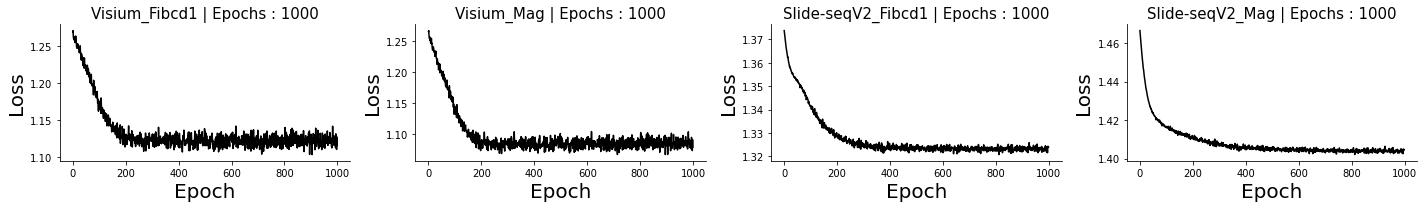

In [15]:
eg.pl.model_diagnostics(losses = losses)

Compute composite representations

In [16]:
ref.composite_representation(by = "feature")

/home/alma.andersson/miniconda3/lib/python3.8/site-packages/anndata-0.7.5-py3.8.egg/anndata/utils.py:141: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")
/home/alma.andersson/miniconda3/lib/python3.8/site-packages/anndata-0.7.5-py3.8.egg/anndata/utils.py:141: UserWarning: Layer 'var' converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


Visualized the transferred data

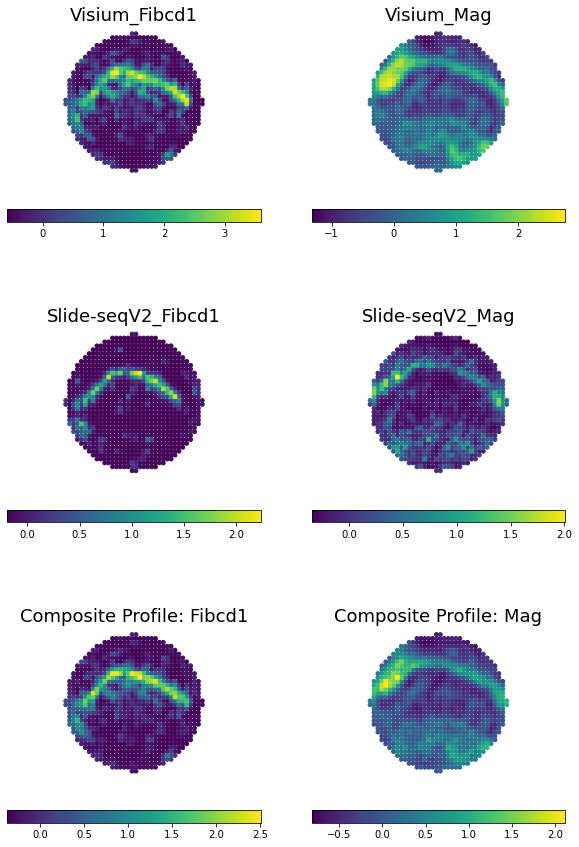

In [19]:
fig,ax = eg.pl.visualize_transfer(ref,
                                  attributes = GENES,
                                  n_cols = 2,
                                  side_size = 5,
                                  quantile_scaling = False,
                                  flip_y = True,
                                  show_landmarks = False,
                                  marker_size = 15,
                                  include_colorbar = True,
                                  separate_colorbar = False,
                                  share_colorscale = False,
                                  fontsize = 18,
                                  colorbar_fontsize = 10,
                                  hspace = 0.4,
                                  return_figures = True,
                                 )
if SAVE_MODE:
    if SAVE_MODE: fig.savefig(osp.join(IMG_RES_DIR,"supp","mouse-hippocampus-trans.png"),bbox_inches="tight")